# **Natural Selection as a Means to Optimize Dynamic Weapon-Target Assignment (DWTA)**
* Author: Maj Travis "Flip" Worden, 53 Test and Evaluation Group, Nellis AFB, NV 
* Affiliation: Contributor, Tron Weaponeering System (BRAVO 11 Hackathon, Schofield Barracks, Hawaii, Feb 2024)
* Date: 10 Feb 2024

## **Contents**
- Primer
- BRAVO 11 Hackathon Background
- What is a Genetic Algorithm?
- Core Features
- Demos
- Limitations

## **Demos**
- Demo 1: Single Optimum
- Demo 2: Multiple Optima (JWS Abstraction)
- Demo 3: Complex Design Space (Criticality of Mutation)

### **Primer**

The Dynamic Weapon-Target Assignment problem is a typical constrained combinatorial optimization problem that is designed to maximize the total success of attack against hostile targets in a myriad of warfighting applications. Solving this problem (virtual permutation) effectively allows for rapid, informed decision making while minimizing costs and attrition during contingency operations.

### **BRAVO 11**

At BRAVO 11, The Tron Weaponeering System team led by Maj Louis "Tron" Bloom attempted to tackle DWTA through the first-ever integration of a Genetic Algorithm with the Joint Weaponeering Software (JWS): a modern machine learning approach uniquely positioned to solve this problem.

### **What is a Genetic Algorithm?**

A genetic algorithm (GA) is a search heuristic that is inspired by Charles Darwin's theory of natural evolution (selection). His algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation. The fundamental operations of genetic algorithms include selection, crossover (also known as recombination), and mutation. Each of these three concepts are crucial for a genetic algorithm to function properly.

Genetic algorithms are uniquely postured to solve the DWTA problem because they strike a balance between exploration of the search space and exploitation of the best solutions found. Applied to campaign level planning, the total number of combinations of potential weapons (fuze settings, impact and release parameters, etc.) to target pairings (target type, composition, number) for a campaign level ATO are immense. Tackling this problem via brute force would be futile. As such, it requires a more novel approach to provide both timely and accurate information for decision-makers within a single ATO cycle.

* **How it works.** The Genetic Algorithm functions by randomly initializing batches of *organisms* that compete with other organisms given their spawned parameters. Those who perform better during the iteration survive to future generations and create offspring that contain features similar to their own. Over time, the offspring will take on traits that are more and more optimized for the task at hand, converging on an optimal solution in a fraction of the time that would be required via brute force. To do this, GA's strike a balance between exploration and exploitation. Since the input space can be so large, it's not computationally feasible to attempt every possible input parameter for every possible target. This methodology provides the following distinct advantages for the DWTA problem:

* **Adaptability.** GA's are highly adaptive to various type of optimization problems and can quickly be optimized for a new task. Regardless of whether or not the design variables are discrete, continuous, or a mix of the two, genetic algorithms can be quickly applied to a variety of DWTA problems. For example, this approach can handle a maximizing of probability of destruction alone ($P_d$) or with a combination of other variables ($P_d$ + priority targets, minimizing the use of costly weapons, or otherwise.)

* **Robustness.** Genetic algorithms are also robust to changes and uncertainties in the problem definition. They can handle noisy or incomplete data and are much less likely to get trapped by small changes in the landscape of the problem that other gradient-based algorithms might get caught by. This robustness is crucial to handle the complex nature of DWTA and the changes that may occur during Contested, Degraded, Operations (CDO) in a single ATO cycle.

* **Ability to Deal with Non-linearities and Discontinuities.** Complex design spaces often feature non-linearities and discontinuities that can pose *significant* challenges for traditional optimization methods.

* **Diversity Maintenance and Optimality.** The beauty of the genetic algorithm applied to DWTA is that a complex design space (hundreds of weapons and targets alike) can quickly converge on a tactical solution without fear of generalizing on a non-optimal solution. Through randomization, mutation, and the law of large numbers, the GA will ***always find the optimal solution*** for this computationally constrained problem.




### **Core Features of the Genetic Algorithm**

* **Population-Based Search Mechanism.** In a complex design space, it is often impossible to simulate every potential option and compare the results to find a true empirical optimum. As a result, genetic algorithms operate on a population of potential solutions. This population approach allows for multiple randomizations of the search space to be explored simultaneously. It increases the diversity of the solutions being considered and does not linger on non-optimal regions that can be computationally costly in a dynamic environment. Each individual (or organism) in the population represents a single solution. For the DWTA problem, this could consist of a single aircraft configured with a specific bomb, fuze setting, impact parameter, release parameters, etc. Scaled up, this "individual" could also be considered as the Many-to-Many relationship that an entire ATO Weapons to Target pairing "option" or "wargame" might consist of. For the purpose of this demonstration, we'll illustrate the first in a very simplistic manner:

* **Selection According to Fitness.** In GAs, individuals are selected to contribute to the next generation based on their performance, known as fitness. This is a measure of how well they solve the problem at hand. For a simple application of DWTA, this can be the total $P_d$ the weapon achieves against a static target given it's randomly spawned attack parameters.

* **Crossover.** Once the highest performing individuals in a generation have been identified, they are pulled into a group and cross-bred such that their offspring for the next generation take on a combination of the parents traits. For DWTA, this might take the form of two parents who performed well with an impact angle trait of 65 $^\circ$ and 75 $^\circ$. In this simple case, their child will take on a random value between these two and initialize into the next run with a merging of it's parents traits.

* **Mutation.** Over time, the genetic algorithm and the individuals spawned into each generation will converge on a learned optimal solution. However, if the individuals in the first generation were not spawned with the required traits that cover the global optimum for the problem at hand, it is possible that the algorithm will terminate with a less than optimal solution. To combat this, the GA uses a low-rate **mutation** which gives a small subset of the population in each generation a completely random set of traits that have not been bred from their parents. This can be either a complete reinitialization or a single trait mutation different from it's parents. This is known as a hyperparameter in machine learning.

### **Step-by-Step Example**

This segment will be demonstrated in the Python coding language. This example is designed for instructional purposes only to provide an intuition for how the GA might be applied to DWTA. It is not designed to demonstrate campaign level DWTA, although this is a target for the JWS/GA effort.

For this simple demonstration, our target will be finding the optimal impact angle and velocity for a weapon against a specific static target.

First, we import required packages:

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import imageio.v2
from datetime import datetime

#Suppress nuisance warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)



%matplotlib inline

Next, we'll define a class that contains a single combination of possible inputs to the system. To humanize the problem, this is functionally identical to any organism entering the world. In the case of a dog, for instance, it has a species, size, color, length, and many other traits. In Python, a Class is the type of method that handles this exact thing. Multiple individuals of a class can be initialized in much the same way the multiple individuals of the type "Human" can be born. For this demonstration, our class will be named `Weapon`

For this problem, our `Weapon` will have two traits: `Impact_Angle` and `Velocity`. Let's write the code for our species of organisms named `Weapon`:

In [39]:
class Weapon:
    def __init__(self, impact_angle=None, velocity=None):
        self.impact_angle = impact_angle if impact_angle is not None else np.random.uniform(35, 90)
        self.velocity = velocity if velocity is not None else np.random.uniform(600, 1500)
        self.fitness = self.calc_fitness()

We've now initialized our `Weapon` class with the desired features. We've also set a random initialization for the two features as:

* Impact_angle: $35^\circ$ to $90^\circ$
* Velocity: 600 to 1500 fps

Note that we've only initialized what it means to be an individual of the class `Weapon`. We haven't actually told it to do anything yet. This class can be considered the recipe-book for creating more in the future.

### **Fitness**

Next, we need to determine our measure of fitness. For this example, we'll set our fitness function to the following:

$$
\begin{align}

fitness = \frac{1}{1 + distance}

\end{align}
$$


For this example, fitness will be a function of the two-dimensional distance away from the optimal release parameter. The denominator has a value of 1 added to it so that weapons that converge on the exact solution will not crash the system (will result in a fitness of 1 instead of infinity).

Note: Although this example implies that the optimal solution is known (distance is directly measured from the known value), it is not required or even desired to do this with real problems. JWS is computationally expensive, and so each individual or `Attack` generated by a GA applied to JWS will return a $P_d$ from a single run of the software, which can then be applied indirectly to the fitness function to determine optimal input parameters, as an example.

We'll use this to update the class with our fitness function. In this demonstration, the optimal point is:

$$ 
\begin{align}

\text{Optimal Release Parameters:} \\
\text{Impact Angle}: 85^\circ \\
\text{Impact Velocity}: 900 fps 

\end{align}
$$

In [40]:
class Weapon:
    def __init__(self, impact_angle=None, velocity=None, mutated=False):
        self.impact_angle = impact_angle if impact_angle is not None else np.random.uniform(35, 90)
        self.velocity = velocity if velocity is not None else np.random.uniform(600, 1500)
        self.mutated = mutated  # Flag to indicate mutation
        # Note: We'll calculate fitness later with optimal_point passed as a parameter
    def calc_fitness(self, optimal_point, fitness="default"):
        
        if fitness == "default":
            dist = np.sqrt((self.impact_angle - optimal_point[0])**2 + (self.velocity - optimal_point[1])**2)
            self.fitness = 1 / (1 + dist)
        elif fitness == "landscape":
            self.fitness = fitness_function(self.impact_angle, self.velocity)


### **Crossover (Breeding)**

Next, we'll define our crossover function. This determines how well performing individuals will breed to exist in the next generation. We'll use two parents for this example, but note that GA's are not constrained by two parent crossover functions.

In [41]:
def crossover(parent1, parent2):
    
    jitter1 = abs(parent1.impact_angle - parent2.impact_angle)*.5
    jitter2 = abs(parent1.velocity - parent2.velocity)*.5

 # Generate random values between the two parents' traits for the offspring
    child1_impact_angle = np.random.uniform(min(parent1.impact_angle, parent2.impact_angle)-jitter1, max(parent1.impact_angle, parent2.impact_angle)+jitter1)
    child1_velocity = np.random.uniform(min(parent1.velocity, parent2.velocity)-jitter2, max(parent1.velocity, parent2.velocity)+jitter2)
    
    child2_impact_angle = np.random.uniform(min(parent1.impact_angle, parent2.impact_angle)-jitter1, max(parent1.impact_angle, parent2.impact_angle)+jitter1)
    child2_velocity = np.random.uniform(min(parent1.velocity, parent2.velocity)-jitter2, max(parent1.velocity, parent2.velocity)+jitter2)
    
    child1 = Weapon(impact_angle=child1_impact_angle, velocity=child1_velocity)
    child2 = Weapon(impact_angle=child2_impact_angle, velocity=child2_velocity)
    
    return child1, child2


### **Mutation** 

To prevent local optimums, we need to incorporate mutations. This mimics how the theory of evolution occurs: through random mutations across multiple generations, an organism can change to adapt to and optimize survival in its environment. 

For this demonstration, we'll apply mutation to 1% of the population at the start of every generation. For simplicity, this will be a complete randomization of both impact velocity and angle.


In [42]:
def mutate(weapon, mutation_rate, optimal_point):
    mutated = False  # Track if mutation occurs
    if np.random.rand() < mutation_rate:
        weapon.impact_angle = np.random.uniform(35, 90)
        weapon.velocity = np.random.uniform(600, 1500)
        mutated = True
        
    if mutated:
        weapon.mutated = True  # Mark individual as mutated
        
    weapon.calc_fitness(optimal_point, fitness=fitness)  # Recalculate fitness with the current optimal_point



### **Selection**

Selection occurs after each of the `Weapon`'s spawned in the generation execute their attack and the results are determined. 

In [43]:
def selection(population):
    fitness_scores = []
    for i in population:
        fitness_scores += [i.fitness]
    
    parents = np.random.choice(population, size=2, replace=False, p=fitness_scores/np.sum(fitness_scores))
    return parents

Our selection function calls the fitness function from the class and calculates the fitness for every `Warrior` spawned in the generation. This is functionally identical to having a battery of weapons or weapon-target pairings on the ATO that JWS then runs (one at a time) to return the $P_d$ as a part of the fitness function to measure performance. 

The `<size>` value above indicates the amount of `Weapons` that are kept from the previous generation. To artificially slow down convergence, we'll set this to a relatively high value:

### **Initialize Population**

Now, we only have to define how we initialize our population, then setup the main Genetic Algorithm code. We'll also define a population size within each generation (the number of attacks tested in a single iteration).

In [44]:
def create_generation(pop_size, optimal_point, fitness="default"):
    population = [Weapon() for _ in range(pop_size)]
    
    for weapon in population:
        weapon.calc_fitness(optimal_point, fitness=fitness)
        
    return population

### **Evolution**

Now we setup the main code for the algorithm:

In [45]:
def evolve(population, generations, mutation_rate, optimal_point, fitness="default"):
    for generation in range(generations):
        new_population = []
        while len(new_population) < len(population):
            parent1, parent2 = selection(population)
            child1, child2 = crossover(parent1, parent2)
            mutate(child1, mutation_rate, optimal_point)
            mutate(child2, mutation_rate, optimal_point)
            new_population += [child1, child2]
        population = new_population[:len(population)]  # Ensure population size stays constant
        yield population


Fundamentally, each generation of the Genetic Algorithm functions by accomplishing the following steps.

For every generation until the generation limit is met:
1. Calculate the fitness for each `Weapon` in the generation
2. Sort by the highest performing `Weapon`s, draw a line where the survival cutoff is, then kill those who don't make the cut.
3. Breed the survivors to create a new population for the next generation that take on a merging of their parent's traits
4. Spawn random mutations at the desired rate to enter the next generation.

In [46]:
#Helper visualization function
def create_gif(image_folder, output_path, duration=1.0):
    images = []
    for file_name in sorted(os.listdir(image_folder), key=lambda x: int(x.split('_')[1].split('.')[0])):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(output_path, images, duration=duration, loop=0)

    # #Delete PNG files
    # for file_name in os.listdir(image_folder):
    #     if file_name.endswith('.png'):
    #         os.remove(os.path.join(image_folder, file_name))

    # Display the GIF
    display(HTML(f'<img src="{output_path}" />'))  


In [47]:
#Helper visualization code
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

def get_color_for_value(value, min_val, max_val):
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.coolwarm)
    # Inverse the logic for the color scale
    return mapper.to_rgba(max_val - value + min_val)


import matplotlib.pyplot as plt
import numpy as np
import os  # Ensure os is imported if not already present in your script

def plot_population(population, generation, images_dir, optimal_point, fitness="default"):
    plt.figure(figsize=(10, 6))

    # Calculate averages
    avg_impact_angle = np.mean([weapon.impact_angle for weapon in population])
    avg_velocity = np.mean([weapon.velocity for weapon in population])

    if fitness == "default":
        # Plot the optimal point
        plt.scatter(optimal_point[0], optimal_point[1], color='red', s=100, edgecolors='k', label='Optimal Point')

    elif fitness == "landscape":
        # Generate x and y values for the fitness landscape
        x_values = np.linspace(35, 90, 100)
        y_values = np.linspace(600, 1500, 100)
        X, Y = np.meshgrid(x_values, y_values)
        Z = fitness_function(X, Y)  # Make sure fitness_function is defined
        
        # Plot the heatmap of the fitness landscape
        contourf = plt.contourf(X, Y, Z, cmap='nipy_spectral', alpha=0.3, levels=np.linspace(Z.min(), Z.max(), 100))
        cbar = plt.colorbar(contourf)  # Add a color bar to the right side of the plot
        cbar.set_label('Probability of Destruction ($P_d$)')  # You can customize this label as needed

    # Plot each weapon in the population
    for weapon in population:
        color = 'green' if weapon.mutated else 'blue'
        plt.scatter(weapon.impact_angle, weapon.velocity, color=color, alpha=0.3)
    
    # Dummy plots for legend
    plt.scatter([], [], color='blue', label='Weapon')
    plt.scatter([], [], color='green', label='Mutated Weapon')
    
    plt.xlim(35, 90)
    plt.ylim(600, 1500)
    plt.xlabel('Impact Angle (degrees)')
    plt.ylabel('Velocity (fps)')
    plt.title(f'Generation {generation + 1}')
    
    # Display the averages inside the plot area
    plt.text(0.01, 0.05, f'Avg. Impact Angle: {avg_impact_angle:.2f}', transform=plt.gca().transAxes, fontsize=9, ha='left', va='bottom')
    plt.text(0.01, 0.01, f'Avg. Velocity: {avg_velocity:.2f}', transform=plt.gca().transAxes, fontsize=9, ha='left', va='bottom')
    
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(images_dir, f"generation_{generation + 1}.png"))
    plt.close()



### **Demo 1: Single Optimal Point**

Now we'll let the algorithm run to show its result. We'll initialize 50 `Weapon`s with random impact parameters, and set the limit to 50 generations. First let's create a function to cleanup the call for the GA:

In [48]:
#Display generation 1, 2, 5, 10, 20, and 50:
def display_image_square(images):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def run_genetic_algorithm(generation_limit, mutation_rate, pop_size, fitness="default", optimal_point=[85,900], output_type="gif"):
    """Run the genetic algorithm given the desired input parameters"""

    population = create_generation(pop_size=pop_size, optimal_point=optimal_point, fitness=fitness)
    
    #Directory to save images
    images_dir = "ga_plots"
    os.makedirs(images_dir, exist_ok=True)

    for gen_number, gen_population in enumerate(evolve(population, generation_limit, mutation_rate, optimal_point)):
        plot_population(gen_population, gen_number, images_dir, optimal_point, fitness=fitness)

    images = [imageio.imread("ga_plots/generation_1.png"),imageio.imread("ga_plots/generation_2.png"),
        imageio.imread("ga_plots/generation_5.png"),imageio.imread("ga_plots/generation_10.png"),
        imageio.imread("ga_plots/generation_20.png"),imageio.imread("ga_plots/generation_50.png")]

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    if output_type == "image":   
        display_image_square(images)

    elif output_type == "gif":   
        # Call this function after generating all images
        create_gif(images_dir, f'ga_evolution_{fitness}_{timestamp}.gif', duration=0.5)

    elif output_type == "all":
        display_image_square(images)
        create_gif(images_dir, f'ga_evolution_{fitness}_{timestamp}.gif', duration=0.5)



        


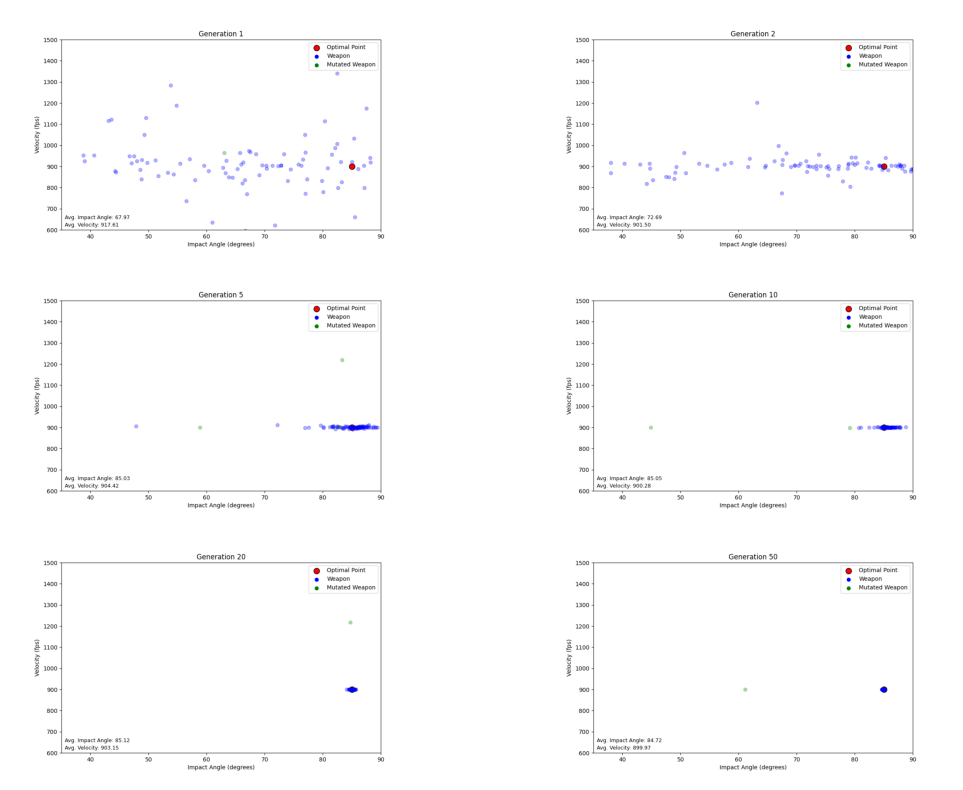

In [49]:
generation_limit = 50
mutation_rate = .01
pop_size = 100
fitness = "default"
optimal_point = [85, 900]
output_type = "all"

run_genetic_algorithm(generation_limit, mutation_rate, 
                    pop_size, fitness=fitness, 
                    optimal_point=optimal_point, output_type=output_type)



With this, we can clearly see the children rapidly converging on the optimal solution of 85 degrees and 900 fps. For single point optimums, this point can easily shift and the algorithm will find a new solution. The following is an example with the optimal velocity set to 1200 and angle set to 60:

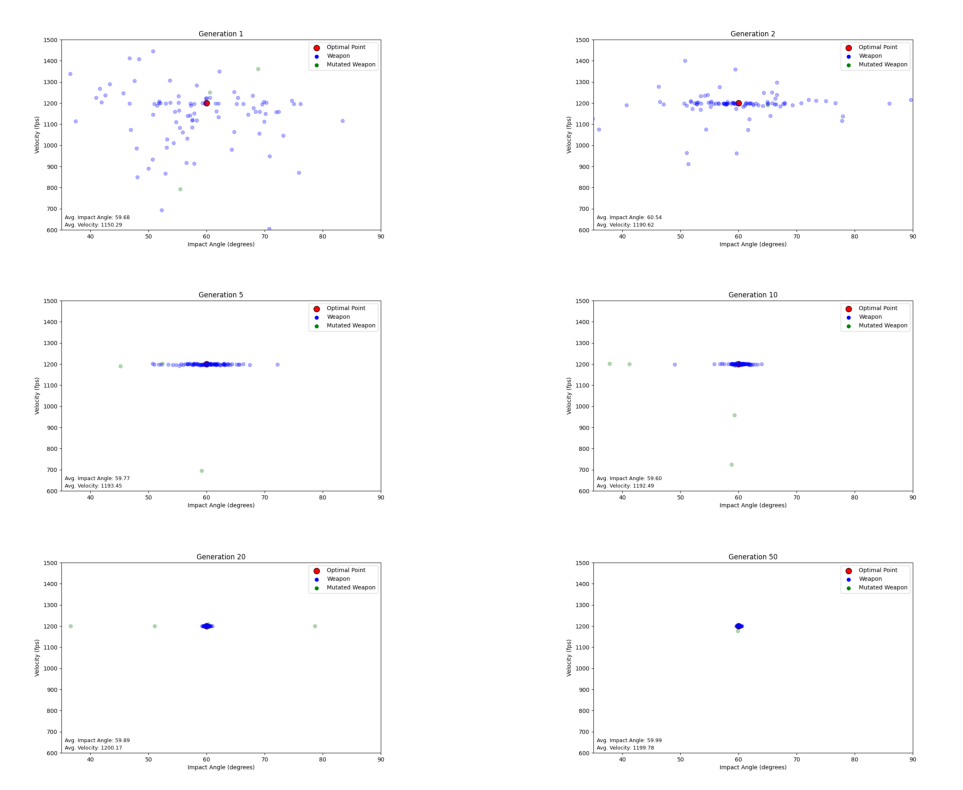

In [50]:
generation_limit = 50
mutation_rate = .01
pop_size = 100
fitness = "default"
optimal_point = [60, 1200]
output_type = "image"

run_genetic_algorithm(generation_limit, mutation_rate, 
                    pop_size, fitness=fitness, 
                    optimal_point=optimal_point, output_type=output_type)


### **Demo 2. Multiple Optima (JWS $P_d$ Abstraction)**

Despite this, **what happens if there are multiple optimum, and the decision space is more complex than a single target value?**

The measure of performance is often not as simple as calculating the distance between the current parameters and a known optimum. For the case of JWS, we can consider the "distance" metric as a measure of divergence from a desired optimum $P_d$. In these cases, it's very likely that there are local maxima associated with certain weapons and release/impact settings. As a result, it's relevant to illustrate how the genetic algorithm handles a landscape that has more than a single maxima (both local and global). To do this, let's first map an equation that creates two optimal regions, with one having a higher value:

In [51]:
def fitness_function(x, y):
    # Parameters for the Gaussian peaks (Will be used later)
    peak1_x = 70
    peak1_y = 1300
    peak1_sigma_x = 5
    peak1_sigma_y = 100

    peak2_x = 50
    peak2_y = 800
    peak2_sigma_x = 7
    peak2_sigma_y = 100

    # Calculate Gaussian peaks
    peak1 = np.exp(-((x - peak1_x) ** 2 / (2 * peak1_sigma_x ** 2) + (y - peak1_y) ** 2 / (2 * peak1_sigma_y ** 2)))
    peak2 = np.exp(-((x - peak2_x) ** 2 / (2 * peak2_sigma_x ** 2) + (y - peak2_y) ** 2 / (2 * peak2_sigma_y ** 2)))

    # Combine the peaks to create the fitness landscape
    landscape = 0.9 * peak1 + 0.5 * peak2  # Adjust weights to control relative importance of peaks

    if np.isscalar(x) and np.isscalar(y):
        # If inputs were scalars, return the single landscape value
        return landscape
    else:
        # If inputs were arrays, return the array of landscape values
        return landscape

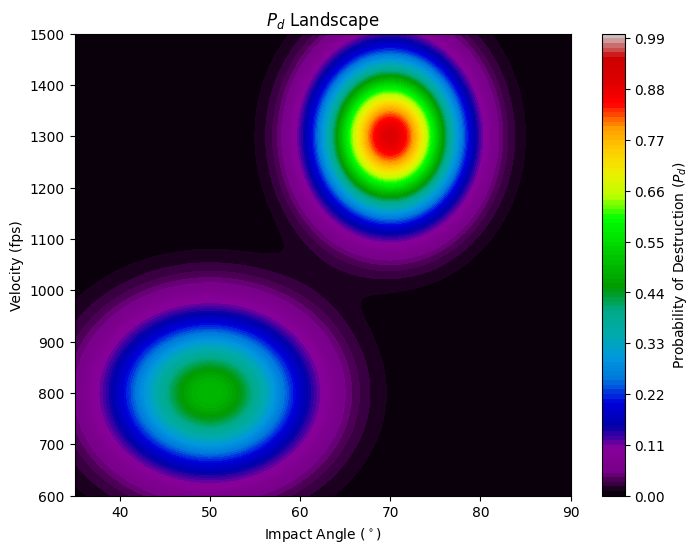

In [52]:
x_values = np.linspace(35, 90, 100)
y_values = np.linspace(600, 1500, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = fitness_function(X, Y)

# Increase the number of contour levels to get more color divisions
num_levels = 100  # Adjust this value to increase/decrease the number of color divisions
levels = np.linspace(0, 1, num_levels + 1)  # Ensure the levels cover the range of fitness values (0 to 1)

# Plot the fitness landscape
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, cmap='nipy_spectral', levels=levels)
plt.colorbar(label='Probability of Destruction ($P_d$)')
plt.xlabel('Impact Angle ($^\circ$)')
plt.ylabel('Velocity (fps)')
plt.title('$P_d$ Landscape')
plt.show()

The plot above shows a global maximum (best solution) at 70 degrees impact angle and 1300 impact velocity. A local optimum exists at 50 degrees and 800 fps. Now, if we use this landscape connected to the Genetic Algorithm, we can observe how the algorithm behaves with multiple optima. For this, we just need to change the fitness function to map against this landscape. 

This is the beauty of the GA. Since the fitness function is the only module required to update the optimization, the GA can be rapidly modified to adapt to new priorities (Changing target priorities, or changing the weighting towards specific factors like weapon use, standoff distance, etc.)

Now we'll update the fitness function and call the GA for this new method:

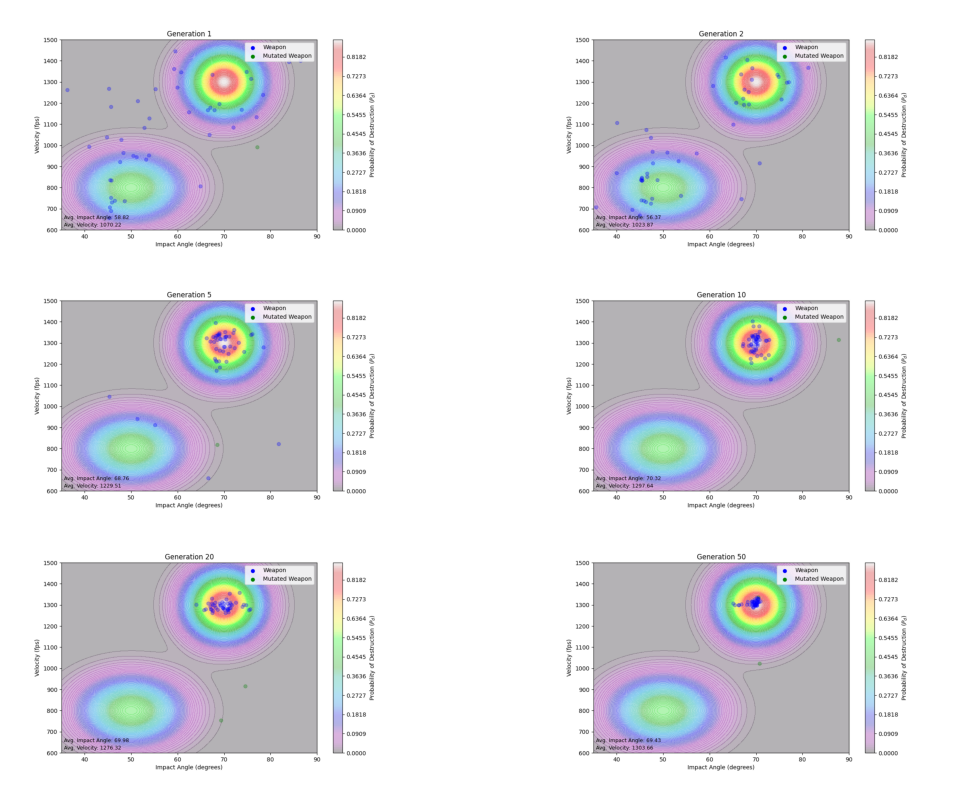

In [53]:
generation_limit = 50
mutation_rate = .01
pop_size = 50
fitness = "landscape"
optimal_point = None
output_type = "all"

run_genetic_algorithm(generation_limit, mutation_rate, 
                    pop_size, fitness=fitness, 
                    optimal_point=optimal_point, output_type=output_type)



Here, we can see that the algorithm quickly converges to the global maximum. This is due to the fact that the initial population in generation 1 has at least one input combination that is feasible, which results in a very fast convergence. However, this will often not be the case. When the design space (range of possible input combinations) is large and the optimal output is small, it's very possible that the first generation will not have an individual that is close to the optimal solution to converge towards.

Additionally, it's important to note that although the optimal $P_d$ landscape is illustrated above, in the real-world this visualization will be hidden from the user. For the purpose of this demonstration, it has been shown to illustrate the performance of the algorithm. This is why it is important to setup a GA properly, as there will be no confirmation in the real-world that where the algorithm converges is the true optimum. A thorough understanding of machine learning and hyperparameter tuning is crucial to converge on a truly optimal answer.

### **Demo 3: Complex Input Spaces (Criticality of Mutation)**

For our third and final demonstration, we'll simulate what it might look like to have a complex input space that prevents early generations from randomly guessing an optimal solution. For this, we'll initialize the generation 1 population far from the optimal values and see how the algorithm interacts:

To do this, we need to update our `create_generation` function:

In [64]:
def create_generation(pop_size, optimal_point, fitness="default"):
    population = []
    for _ in range(pop_size):  # Use '_' for unused loop variable
        if np.random.rand() < 0.5:
            impact_angle_range = (35, 45)
            velocity_range = (1300, 1500)
        else:
            impact_angle_range = (80, 90)
            velocity_range = (600, 800)

        impact_angle = np.random.uniform(*impact_angle_range)
        velocity = np.random.uniform(*velocity_range)
        new_weapon = Weapon(impact_angle=impact_angle, velocity=velocity)
        population.append(new_weapon)  # Correctly append the new instance

    for weapon in population:
        weapon.calc_fitness(optimal_point, fitness=fitness)
        
    return population


Now we'll rerun the same test as before, except we'll set the mutation rate to 0. This means that no individuals will spawn outside of the limited input parameters. This simulates the initialization missing an optimal input combination, which is likely in a complex, multi-parameter input space:

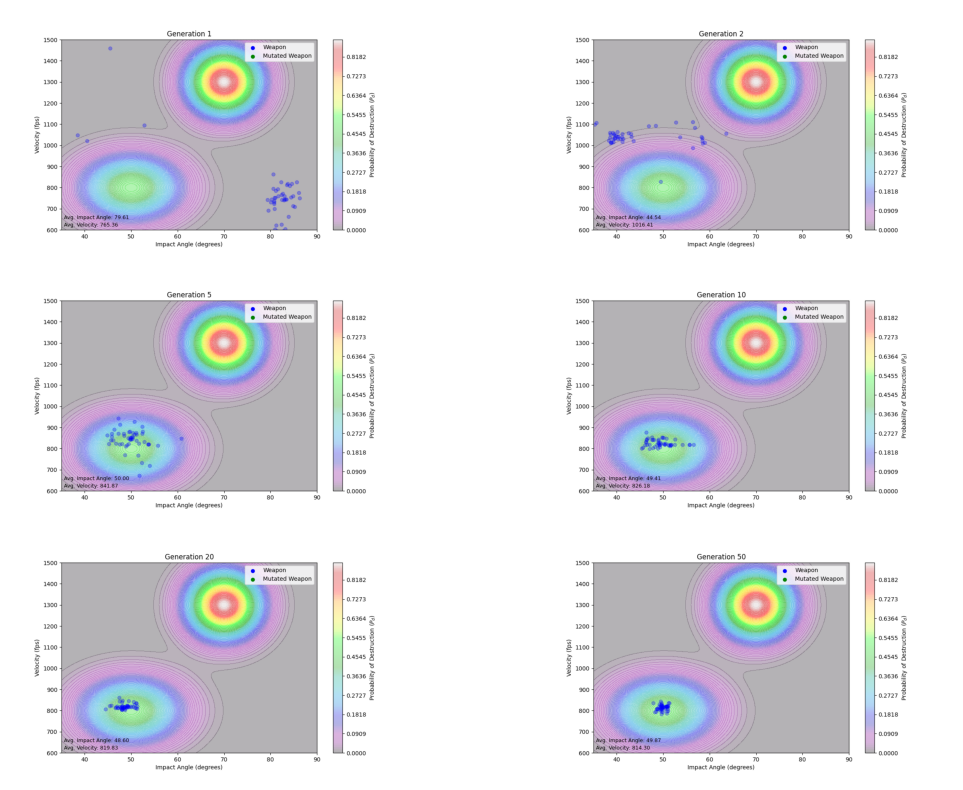

In [66]:
generation_limit = 50
mutation_rate = 0
pop_size = 50
fitness = "landscape"
optimal_point = None
output_type = "all"

run_genetic_algorithm(generation_limit, mutation_rate, 
                    pop_size, fitness=fitness, 
                    optimal_point=optimal_point, output_type=output_type)



The above situation is a perfect illustration why mutation is necessary for true convergence on a global optimum. If there is no opportunity for new truly random input combinations to enter the design space further down in the genealogy, then it will be impossible to truly explore to a global optimal solution. In this case, the algorithm converges only to the best value it has found, and misses the global optimum at 70 degrees and 1300 fps.

## **Limitations**

Genetic algorithms can be a powerful option to find solutions to complex combinatorial problems. However, they do feature some significant limitations that are important to understand before applying to real-world problems:

* **Convergence Time.** GA's can be slow to converge to the optimal solution, especially when the problem is scaled up with particularly large search spaces. Additionally, the time required to find a sufficiently good solution can be unpredictable and may require many generations of evolution to converge.

* **Premature Convergence.** GA's can converge prematurely on a non-optimal solution rather than the global optimum. This is particularly troublesome when this occurs early in the generation cycle and the exploitation is tuned too high. If the input space is complex, premature convergence will not leave enough mutation (randomization) to truly encourage exploration of a better solution, and that information will be withheld from the end user.

* **Parameter Sensitivity.** The performance of a GA is highly sensitive to its hyperparameters, such as population size, mutation rate, crossover rate, and the fitness function selected. Selecting the right tuning of these parameters is critical and may require extensive experimentation or domain knowledge.

* **Scalability.** As the size and complexity of the problem increase, the computational resource and time required by the GA to converge to a good solution balloons exponentially. **This is potentially the most concerning characteristic that throws caution to selecting the baseline genetic algorithm for the JWS DWTA problem**, especially when scaled to the campaign level.

* **No guarantee of finding the Global Optimum**. Beyond all of this, the converged solution by the GA has **no guarantee of being the global optimum**. For the DWTA problem however, if a desired threshold is met (All paired weapon to target $P_d$ > x and average $P_d$ across all pairings > y), then it may not actually matter for the decision maker.

For the last reason stated above, this is why a genetic algorithm might be optimally suited for the specific task at hand. 

## **Conclusion**

The Dynamic Weaponeering Target Assignment problem applied to integration with the Joint Weaponeering Software presents a unique opportunity to apply the Genetic Algorithm to the problem set. Although it has its limitations that should be carefully considered, further developing this approach to the DWTA problem can potentially return massive benefit for the joint force, given that further development yields compelling results in minimal computation time.

For any questions, comments, or concerns, contact Maj Louis "Tron" Bloom or Maj Travis "Flip" Worden at the following addresses:

Maj Louis Bloom: louis.bloom.1@us.af.mil

Maj Travis Worden: travis.worden.1@us.af.mil